## Initial guess estimation example with Orion KL

In [1]:
%matplotlib inline

import os
import sys
import copy
import time
import numpy as np
np.seterr(over='ignore')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed, FloatSlider

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

# VarClump functions
sys.path.append('../../lib/')
from utils import *
from graph import *
from points_generation import *
from initial_guess import *
from variational import *
from gmr import *

target_path = "/Users/mavillan/Repositories/VarClump-docs/paper/"

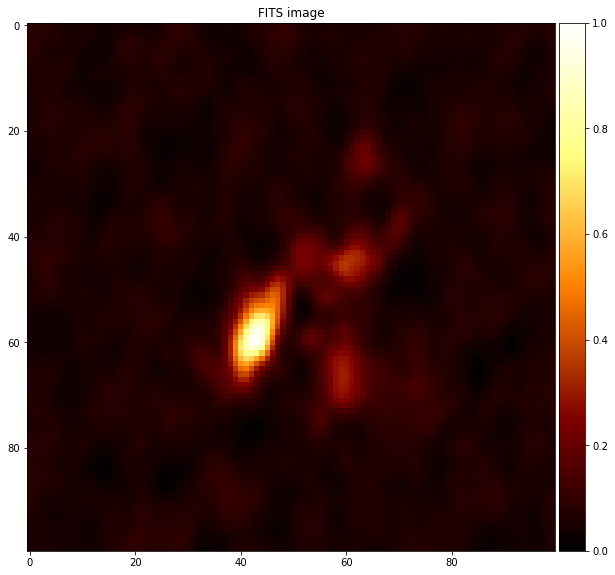

In [2]:
fits_path = '../../data/images/Orion.cont.image.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [3]:
base_level = estimate_rms(data)

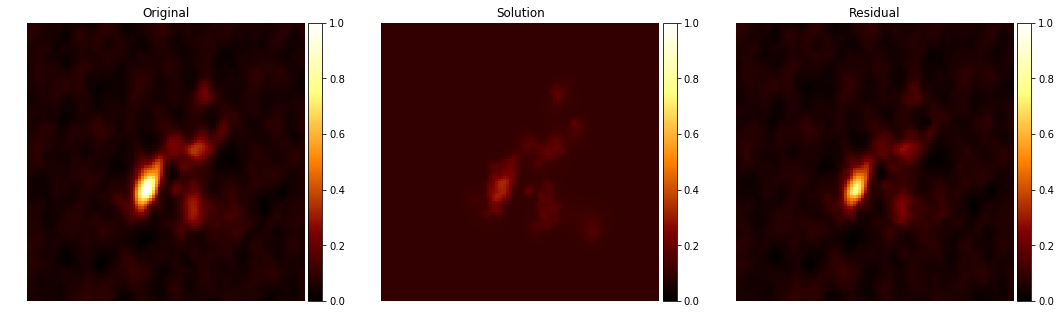

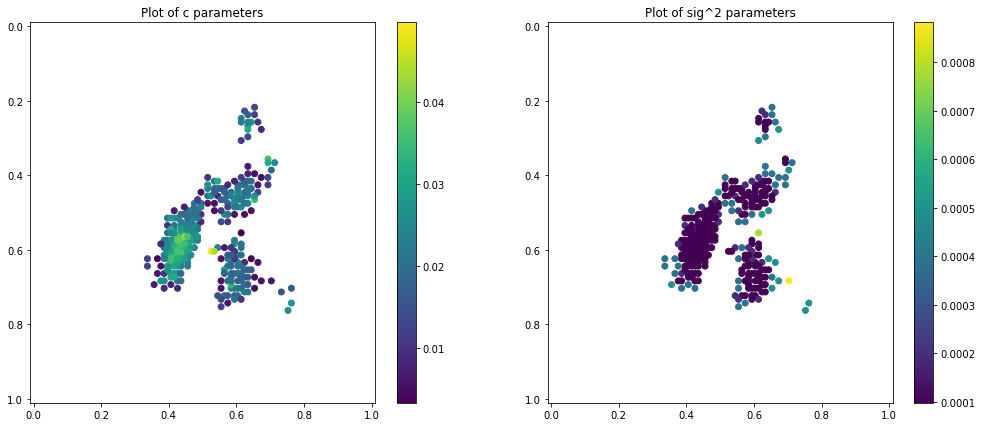

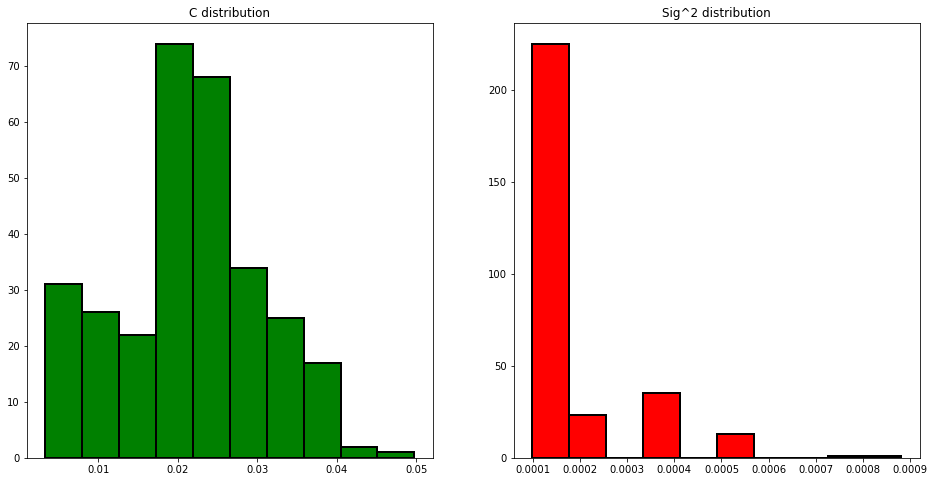

In [14]:
##########################################
# Approach 1
##########################################

# number of points of each type
Nb = 0
Nc = 300
Ne = 4*Nc-4*Nb
points_method = 'random'

if points_method=='random':
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=6.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_generation(Nb)

elif points_method=='halton':
    points = qrandom_centers_generation(dfunc, Nc+Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[Nc:Nc+Ne]
    boundary_points = boundary_generation(Nb)


# right format
xc = center_points[:,0]; yc = center_points[:,1]
xe = collocation_points[:,0]; ye = collocation_points[:,1]
xb = boundary_points[:,0]; yb = boundary_points[:,1]


# visualizing the choosen points
#points_plot(data, center_points=center_points, title="(a)")
#points_plot(data, center_points=collocation_points, title="(b)")


####################################
# Initial parameters estimation
####################################
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')


solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)

### Modified function for visualization purposes

In [19]:
def solution_plot(dfunc, c, sig, xc, yc, dims, base_level=0., mask=None, 
                 resolution=1, title=None, support=5.):
    _xe = np.linspace(0., 1., resolution*dims[0]+2)[1:-1]
    _ye = np.linspace(0., 1., resolution*dims[1]+2)[1:-1]
    len_xe = len(_xe); len_ye = len(_ye)
    Xe,Ye = np.meshgrid(_xe, _ye, sparse=False, indexing='ij')
    xe = Xe.ravel(); ye = Ye.ravel()
    points = np.vstack([xe,ye]).T

    # approximation
    u = u_eval(c, sig, xc, yc, xe, ye, support=support) + base_level
    u = u.reshape(len_xe, len_ye)

    # real data
    f = dfunc(points).reshape(dims)


    # unusable pixels are fixed to 0
    if mask is not None: 
        u[~mask] = 0.
        f[~mask] = 0.
        res[~mask] = 0.

    # original data plot
    plt.figure(figsize=(10,10))
    #plt.subplot(1,3,1)
    ax = plt.gca()
    im = ax.imshow(f, vmin=0., vmax=1., cmap=plt.cm.afmhot)
    #plt.title('Original')
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.savefig(target_path+'orion_original.eps', format='eps', dpi=50)
    plt.plot()
    
    # approximated solution plot
    plt.figure(figsize=(10,10))
    #plt.subplot(1,3,2)
    ax = plt.gca()
    im = ax.imshow(u, vmin=0., vmax=1., cmap=plt.cm.afmhot)
    #plt.title('Solution')
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.savefig(target_path+'orion_initial.eps', format='eps', dpi=50)
    plt.show()

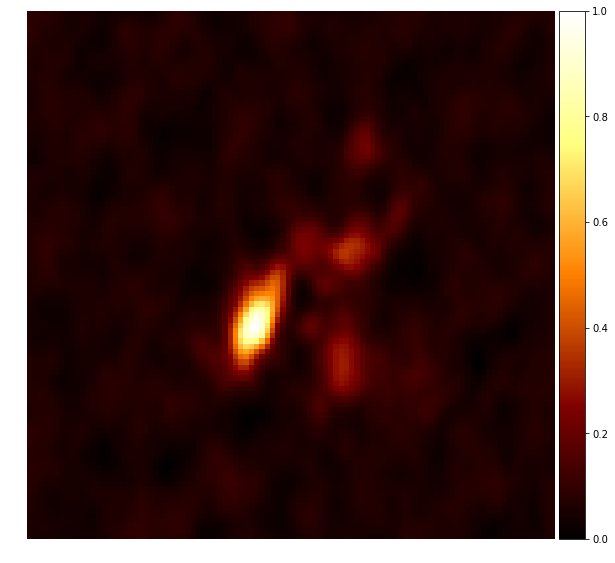

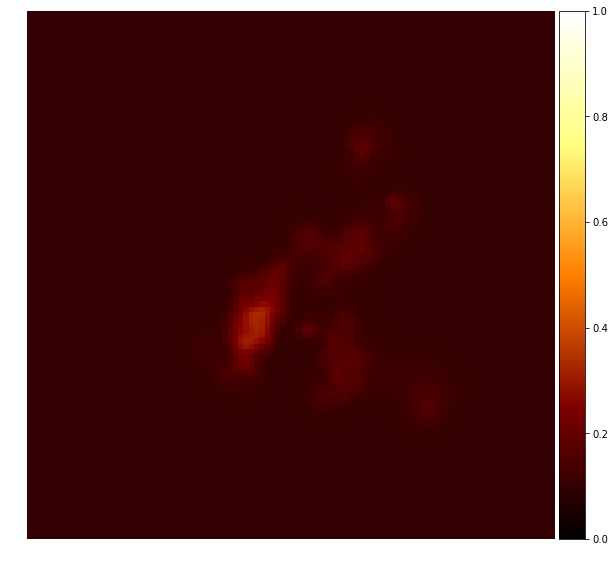

In [20]:
solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)